# Disaster Classification using LSTM with PyTorch

This notebook builds a disaster classification model using LSTM neural networks to classify tweets into one of these categories:
- 0: No disaster
- 1: Earthquake
- 2: Flood
- 3: Hurricane
- 4: Tornado
- 5: Wildfire

We'll use PyTorch to implement the LSTM model and perform the classification.

## Import Libraries

In [1]:
# %pip install seaborn scikit-learn tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from collections import Counter
import re
from tqdm.notebook import tqdm

c:\Users\aksha\miniconda3\envs\mlclass\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


## Load and Explore Data

In [3]:
# Load the preprocessed dataset with specified encoding
df = pd.read_csv('../data-preprocessing/combined_dataset.csv', encoding='utf-16')

# Display basic information
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (191970, 2)


,label,text
0,0,tappanakii with happybirthday
1,0,why you should start paying attention to pro s...
2,0,me before sending a risky text vs me after it ...
3,0,capterwin
4,0,lot of blackberry lane winter theme cross stit...


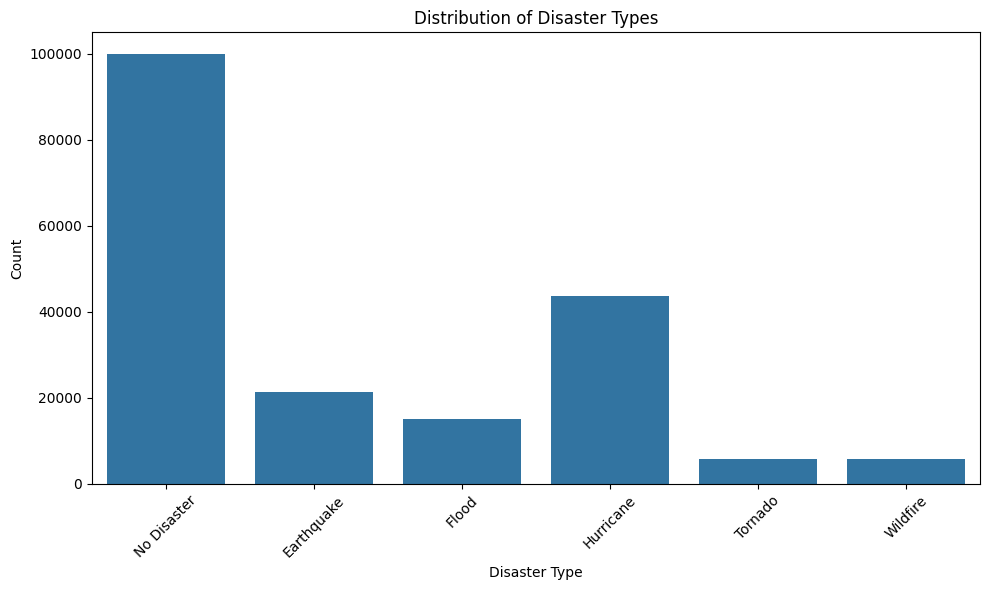

In [4]:
# Check class distribution
class_counts = df['label'].value_counts().sort_index()
disaster_types = ['No Disaster', 'Earthquake', 'Flood', 'Hurricane', 'Tornado', 'Wildfire']

plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xticks(class_counts.index, disaster_types, rotation=45)
plt.xlabel('Disaster Type')
plt.ylabel('Count')
plt.title('Distribution of Disaster Types')
plt.tight_layout()
plt.show()

## Text Preprocessing

In [ ]:
# Clean text function
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove special characters and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Fill missing values with an empty string
df['text'] = df['text'].dropna()

# Apply cleaning to the text column
df['cleaned_text'] = df['text'].apply(clean_text)

# Display sample of cleaned texts
pd.DataFrame({
    'Original': df['text'].head(),
    'Cleaned': df['cleaned_text'].head()
})

AttributeError: 'float' object has no attribute 'lower'

## Tokenization and Vocabulary Building

In [ ]:
# Build vocabulary
def build_vocabulary(texts, max_vocab_size=10000):
    word_counts = Counter()
    for text in texts:
        words = text.split()
        word_counts.update(words)
    
    # Get most common words
    vocab = ['<PAD>', '<UNK>'] + [word for word, _ in word_counts.most_common(max_vocab_size-2)]
    word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    
    return vocab, word_to_idx

# Tokenize text
def tokenize(text, word_to_idx, max_length=50):
    words = text.split()
    tokens = [word_to_idx.get(word, word_to_idx['<UNK>']) for word in words]
    
    # Pad or truncate to fixed length
    if len(tokens) < max_length:
        tokens = tokens + [word_to_idx['<PAD>']] * (max_length - len(tokens))
    else:
        tokens = tokens[:max_length]
    
    return tokens

# Build vocabulary from the cleaned texts
MAX_VOCAB_SIZE = 10000
MAX_LENGTH = 50

vocab, word_to_idx = build_vocabulary(df['cleaned_text'], MAX_VOCAB_SIZE)
print(f"Vocabulary size: {len(vocab)}")

# Tokenize texts
df['tokens'] = df['cleaned_text'].apply(lambda x: tokenize(x, word_to_idx, MAX_LENGTH))

Vocabulary size: 10000


## Split Data into Train, Validation, and Test Sets

Training set: 115182 samples
Validation set: 38394 samples
Test set: 38394 samples


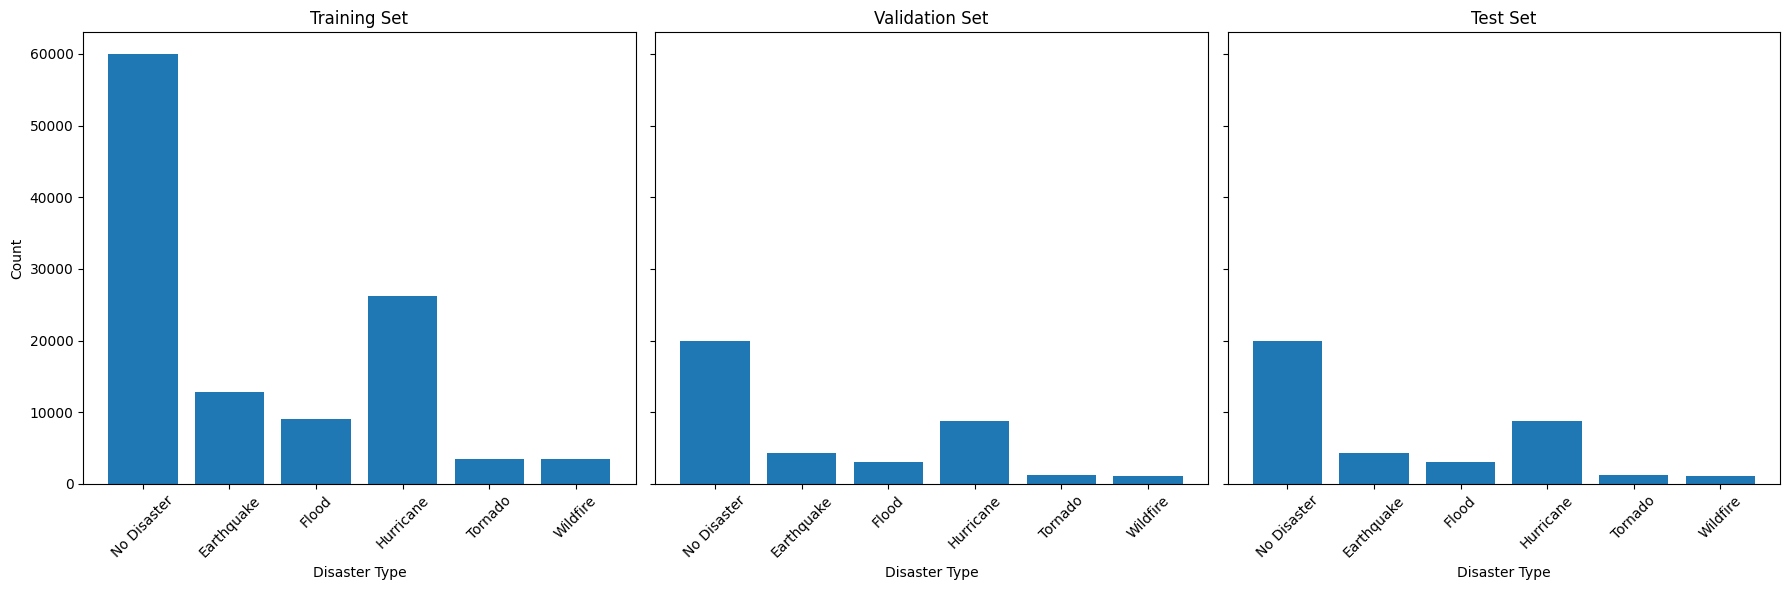

In [ ]:
# Extract features and labels
X = np.array(df['tokens'].tolist())
y = np.array(df['label'])

# First split: 80% train+val, 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Second split: 75% train, 25% validation (from the 80% train+val)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Plot distribution of disaster types in training, validation, and test sets
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Training set distribution
train_counts = pd.Series(y_train).value_counts().sort_index()
axes[0].bar(train_counts.index, train_counts.values)
axes[0].set_xticks(train_counts.index)
axes[0].set_xticklabels(disaster_types, rotation=45)
axes[0].set_title('Training Set')
axes[0].set_xlabel('Disaster Type')
axes[0].set_ylabel('Count')

# Validation set distribution
val_counts = pd.Series(y_val).value_counts().sort_index()
axes[1].bar(val_counts.index, val_counts.values)
axes[1].set_xticks(val_counts.index)
axes[1].set_xticklabels(disaster_types, rotation=45)
axes[1].set_title('Validation Set')
axes[1].set_xlabel('Disaster Type')

# Test set distribution
test_counts = pd.Series(y_test).value_counts().sort_index()
axes[2].bar(test_counts.index, test_counts.values)
axes[2].set_xticks(test_counts.index)
axes[2].set_xticklabels(disaster_types, rotation=45)
axes[2].set_title('Test Set')
axes[2].set_xlabel('Disaster Type')

plt.tight_layout()
plt.show()

## Create PyTorch Dataset and DataLoader

In [ ]:
class DisasterDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = DisasterDataset(X_train, y_train)
val_dataset = DisasterDataset(X_val, y_val)
test_dataset = DisasterDataset(X_test, y_test)

# Create data loaders
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

## Define LSTM Model

In [ ]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        
        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout if n_layers > 1 else 0,
                           batch_first=True)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected layer
        fc_input_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(fc_input_dim, output_dim)
        
    def forward(self, text):
        # text shape: [batch size, sentence length]
        
        # Generate embeddings
        embedded = self.embedding(text)  # shape: [batch size, sentence length, embedding dim]
        
        # Pass through LSTM
        output, (hidden, cell) = self.lstm(embedded)
        
        # Extract the final forward and backward hidden states if bidirectional
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
        
        # Apply dropout
        hidden = self.dropout(hidden)
        
        # Pass through linear layer
        output = self.fc(hidden)
        
        return output

## Initialize Model and Define Hyperparameters

In [ ]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Model hyperparameters
VOCAB_SIZE = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 6  # Number of disaster classes
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = word_to_idx['<PAD>']

# Initialize model
model = LSTMClassifier(
    VOCAB_SIZE, 
    EMBEDDING_DIM, 
    HIDDEN_DIM, 
    OUTPUT_DIM, 
    N_LAYERS, 
    BIDIRECTIONAL, 
    DROPOUT, 
    PAD_IDX
)

# Move model to the device
model = model.to(device)

# Print model summary
print(model)
print(f"The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")

Using device: cuda
LSTMClassifier(
  (embedding): Embedding(10000, 100, padding_idx=0)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=6, bias=True)
)
The model has 1,632,326 trainable parameters


## Define Loss Function and Optimizer

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training and Evaluation Functions

In [ ]:
def train(model, iterator, optimizer, criterion, device):
    
    # Set model to training mode
    model.train()
    
    epoch_loss = 0
    epoch_acc = 0
    
    # Progress bar for training
    progress_bar = tqdm(iterator, desc='Training')
    
    for batch in progress_bar:
        # Get batch data
        text, labels = batch
        text = text.to(device)
        labels = labels.to(device)
        
        # Reset gradients
        optimizer.zero_grad()
        
        # Forward pass
        predictions = model(text)
        
        # Calculate loss
        loss = criterion(predictions, labels)
        
        # Calculate accuracy
        predicted_classes = predictions.argmax(dim=1)
        correct = (predicted_classes == labels).float().sum()
        acc = correct / len(labels)
        
        # Backward pass
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        # Update progress bar
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        progress_bar.set_postfix({'loss': epoch_loss / (progress_bar.n + 1), 'acc': epoch_acc / (progress_bar.n + 1)})
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):
    
    # Set model to evaluation mode
    model.eval()
    
    epoch_loss = 0
    epoch_acc = 0
    
    all_predictions = []
    all_labels = []
    
    # No gradient calculation needed for evaluation
    with torch.no_grad():
        for batch in tqdm(iterator, desc='Evaluating'):
            # Get batch data
            text, labels = batch
            text = text.to(device)
            labels = labels.to(device)
            
            # Forward pass
            predictions = model(text)
            
            # Calculate loss
            loss = criterion(predictions, labels)
            
            # Calculate accuracy
            predicted_classes = predictions.argmax(dim=1)
            correct = (predicted_classes == labels).float().sum()
            acc = correct / len(labels)
            
            # Update total loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            # Save predictions and labels for classification report
            all_predictions.extend(predicted_classes.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator), all_predictions, all_labels

## Training Loop

In [ ]:
# Set number of epochs
N_EPOCHS = 10
PATIENCE = 3  # Number of epochs to wait for improvement before stopping

# Initialize variables to store best validation accuracy
best_valid_acc = 0.0
epochs_no_improve = 0

# Lists to store metrics for plotting
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(N_EPOCHS):
    print(f"Epoch {epoch+1}/{N_EPOCHS}")
    
    # Training phase
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Evaluation phase
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"\tTrain Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"\tVal Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
    
    # Save the best model
    if val_acc > best_valid_acc:
        best_valid_acc = val_acc
        torch.save(model.state_dict(), 'best_disaster_model.pt')
        print(f"\tBest validation accuracy so far! Model saved.")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"\tNo improvement in validation accuracy for {epochs_no_improve} epoch(s).")
    
    # Check early stopping condition
    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break
    
    print("--------------------------------------------------")


Epoch 1/10


Training:   0%|          | 0/1800 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/600 [00:00<?, ?it/s]

	Train Loss: 0.3682 | Train Acc: 89.36%
	Val Loss: 0.1846 | Val Acc: 95.17%
	Best validation accuracy so far! Model saved.
--------------------------------------------------
Epoch 2/10


Training:   0%|          | 0/1800 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/600 [00:00<?, ?it/s]

	Train Loss: 0.1675 | Train Acc: 95.70%
	Val Loss: 0.1574 | Val Acc: 95.85%
	Best validation accuracy so far! Model saved.
--------------------------------------------------
Epoch 3/10


Training:   0%|          | 0/1800 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/600 [00:00<?, ?it/s]

	Train Loss: 0.1308 | Train Acc: 96.54%
	Val Loss: 0.1404 | Val Acc: 96.27%
	Best validation accuracy so far! Model saved.
--------------------------------------------------
Epoch 4/10


Training:   0%|          | 0/1800 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/600 [00:00<?, ?it/s]

	Train Loss: 0.1081 | Train Acc: 97.15%
	Val Loss: 0.1404 | Val Acc: 96.41%
	Best validation accuracy so far! Model saved.
--------------------------------------------------
Epoch 5/10


Training:   0%|          | 0/1800 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/600 [00:00<?, ?it/s]

	Train Loss: 0.0908 | Train Acc: 97.59%
	Val Loss: 0.1481 | Val Acc: 96.49%
	Best validation accuracy so far! Model saved.
--------------------------------------------------
Epoch 6/10


Training:   0%|          | 0/1800 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/600 [00:00<?, ?it/s]

	Train Loss: 0.0737 | Train Acc: 98.04%
	Val Loss: 0.1566 | Val Acc: 96.38%
	No improvement in validation accuracy for 1 epoch(s).
--------------------------------------------------
Epoch 7/10


Training:   0%|          | 0/1800 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/600 [00:00<?, ?it/s]

	Train Loss: 0.0699 | Train Acc: 98.13%
	Val Loss: 0.1569 | Val Acc: 96.56%
	Best validation accuracy so far! Model saved.
--------------------------------------------------
Epoch 8/10


Training:   0%|          | 0/1800 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/600 [00:00<?, ?it/s]

	Train Loss: 0.0519 | Train Acc: 98.61%
	Val Loss: 0.1666 | Val Acc: 96.51%
	No improvement in validation accuracy for 1 epoch(s).
--------------------------------------------------
Epoch 9/10


Training:   0%|          | 0/1800 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/600 [00:00<?, ?it/s]

	Train Loss: 0.0436 | Train Acc: 98.80%
	Val Loss: 0.1841 | Val Acc: 96.42%
	No improvement in validation accuracy for 2 epoch(s).
--------------------------------------------------
Epoch 10/10


Training:   0%|          | 0/1800 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/600 [00:00<?, ?it/s]

	Train Loss: 0.0377 | Train Acc: 98.98%
	Val Loss: 0.2119 | Val Acc: 96.34%
	No improvement in validation accuracy for 3 epoch(s).
Early stopping triggered after 10 epochs.


## Model Fine-Tuning

In [ ]:
# Freeze the LSTM and embedding layers
for param in model.embedding.parameters():
    param.requires_grad = False

for param in model.lstm.parameters():
    param.requires_grad = False

# Print the model to verify which parameters are frozen
for name, param in model.named_parameters():
    print(f"{name}: {'requires_grad=True' if param.requires_grad else 'requires_grad=False'}")
    
# Fine-tune the model with the remaining parameters
N_FINE_TUNE_EPOCHS = 5

# Initialize variables to store best validation accuracy during fine-tuning
best_fine_tune_acc = 0.0

# Lists to store metrics for plotting
fine_tune_train_losses = []
fine_tune_train_accs = []
fine_tune_val_losses = []
fine_tune_val_accs = []

for epoch in range(N_FINE_TUNE_EPOCHS):
    print(f"Fine-tuning Epoch {epoch+1}/{N_FINE_TUNE_EPOCHS}")
    
    # Training phase
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    fine_tune_train_losses.append(train_loss)
    fine_tune_train_accs.append(train_acc)
    
    # Evaluation phase
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
    fine_tune_val_losses.append(val_loss)
    fine_tune_val_accs.append(val_acc)
    
    print(f"\tTrain Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"\tVal Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
    
    # Save the best model during fine-tuning
    if val_acc > best_fine_tune_acc and  val_acc > best_valid_acc:
        best_fine_tune_acc = val_acc
        torch.save(model.state_dict(), 'best_disaster_model.pt')
        print(f"\tBest validation accuracy so far during fine-tuning! Model saved.")
    else:
        print(f"\tNo improvement in validation accuracy during fine-tuning.")
    
    print("--------------------------------------------------")
    
if best_fine_tune_acc > best_valid_acc:
    print("Best model is the fine-tuned model.")
else:
    print("Best model is the model before fine-tuning.")

# Unfreeze the LSTM and embedding layers
for param in model.embedding.parameters():
    param.requires_grad = True

for param in model.lstm.parameters():
    param.requires_grad = True

# Print the model to verify which parameters are unfrozen
for name, param in model.named_parameters():
    print(f"{name}: {'requires_grad=True' if param.requires_grad else 'requires_grad=False'}")

embedding.weight: requires_grad=False
lstm.weight_ih_l0: requires_grad=False
lstm.weight_hh_l0: requires_grad=False
lstm.bias_ih_l0: requires_grad=False
lstm.bias_hh_l0: requires_grad=False
lstm.weight_ih_l0_reverse: requires_grad=False
lstm.weight_hh_l0_reverse: requires_grad=False
lstm.bias_ih_l0_reverse: requires_grad=False
lstm.bias_hh_l0_reverse: requires_grad=False
lstm.weight_ih_l1: requires_grad=False
lstm.weight_hh_l1: requires_grad=False
lstm.bias_ih_l1: requires_grad=False
lstm.bias_hh_l1: requires_grad=False
lstm.weight_ih_l1_reverse: requires_grad=False
lstm.weight_hh_l1_reverse: requires_grad=False
lstm.bias_ih_l1_reverse: requires_grad=False
lstm.bias_hh_l1_reverse: requires_grad=False
fc.weight: requires_grad=True
fc.bias: requires_grad=True
Fine-tuning Epoch 1/5


Training:   0%|          | 0/1800 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/600 [00:00<?, ?it/s]

	Train Loss: 0.0267 | Train Acc: 99.28%
	Val Loss: 0.2163 | Val Acc: 96.42%
	No improvement in validation accuracy during fine-tuning.
--------------------------------------------------
Fine-tuning Epoch 2/5


Training:   0%|          | 0/1800 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/600 [00:00<?, ?it/s]

	Train Loss: 0.0260 | Train Acc: 99.28%
	Val Loss: 0.2212 | Val Acc: 96.40%
	No improvement in validation accuracy during fine-tuning.
--------------------------------------------------
Fine-tuning Epoch 3/5


Training:   0%|          | 0/1800 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/600 [00:00<?, ?it/s]

	Train Loss: 0.0259 | Train Acc: 99.31%
	Val Loss: 0.2235 | Val Acc: 96.40%
	No improvement in validation accuracy during fine-tuning.
--------------------------------------------------
Fine-tuning Epoch 4/5


Training:   0%|          | 0/1800 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/600 [00:00<?, ?it/s]

	Train Loss: 0.0261 | Train Acc: 99.30%
	Val Loss: 0.2227 | Val Acc: 96.40%
	No improvement in validation accuracy during fine-tuning.
--------------------------------------------------
Fine-tuning Epoch 5/5


Training:   0%|          | 0/1800 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/600 [00:00<?, ?it/s]

	Train Loss: 0.0263 | Train Acc: 99.30%
	Val Loss: 0.2263 | Val Acc: 96.40%
	No improvement in validation accuracy during fine-tuning.
--------------------------------------------------
Best model is the model before fine-tuning.
embedding.weight: requires_grad=True
lstm.weight_ih_l0: requires_grad=True
lstm.weight_hh_l0: requires_grad=True
lstm.bias_ih_l0: requires_grad=True
lstm.bias_hh_l0: requires_grad=True
lstm.weight_ih_l0_reverse: requires_grad=True
lstm.weight_hh_l0_reverse: requires_grad=True
lstm.bias_ih_l0_reverse: requires_grad=True
lstm.bias_hh_l0_reverse: requires_grad=True
lstm.weight_ih_l1: requires_grad=True
lstm.weight_hh_l1: requires_grad=True
lstm.bias_ih_l1: requires_grad=True
lstm.bias_hh_l1: requires_grad=True
lstm.weight_ih_l1_reverse: requires_grad=True
lstm.weight_hh_l1_reverse: requires_grad=True
lstm.bias_ih_l1_reverse: requires_grad=True
lstm.bias_hh_l1_reverse: requires_grad=True
fc.weight: requires_grad=True
fc.bias: requires_grad=True


## Plot Training and Validation Curves

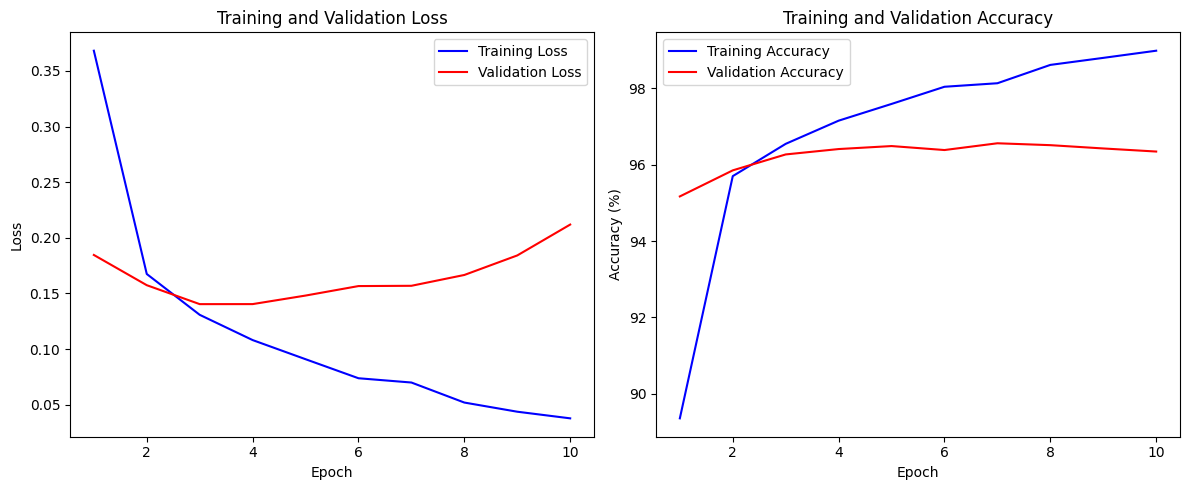

--------------------------------------------------


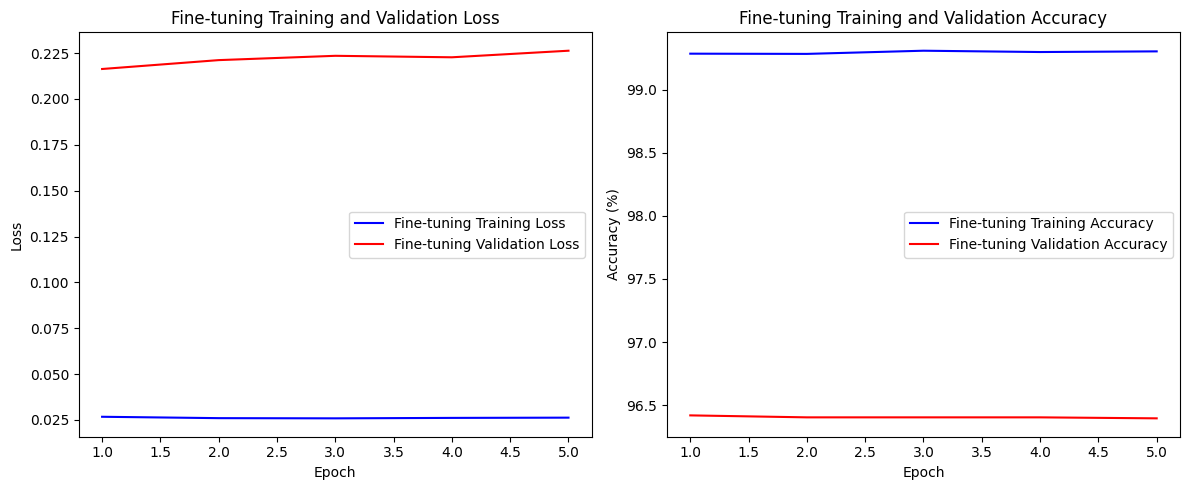

In [ ]:
# Plot loss curves for training and validation
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, N_EPOCHS+1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, N_EPOCHS+1), val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, N_EPOCHS+1), [acc * 100 for acc in train_accs], 'b-', label='Training Accuracy')
plt.plot(range(1, N_EPOCHS+1), [acc * 100 for acc in val_accs], 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

print("--------------------------------------------------")

# Plot loss curves for fine-tuning
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, N_FINE_TUNE_EPOCHS+1), fine_tune_train_losses, 'b-', label='Fine-tuning Training Loss')
plt.plot(range(1, N_FINE_TUNE_EPOCHS+1), fine_tune_val_losses, 'r-', label='Fine-tuning Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Fine-tuning Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, N_FINE_TUNE_EPOCHS+1), [acc * 100 for acc in fine_tune_train_accs], 'b-', label='Fine-tuning Training Accuracy')
plt.plot(range(1, N_FINE_TUNE_EPOCHS+1), [acc * 100 for acc in fine_tune_val_accs], 'r-', label='Fine-tuning Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Fine-tuning Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluate on Test Set

In [ ]:
# Load best model
model.load_state_dict(torch.load('best_disaster_model.pt'))

# Evaluate on test set
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

Evaluating:   0%|          | 0/600 [00:00<?, ?it/s]

Test Loss: 0.1640 | Test Acc: 96.48%


## Classification Report and Confusion Matrix

Classification Report:
              precision    recall  f1-score   support

 No Disaster       0.97      0.99      0.98     20000
  Earthquake       0.96      0.95      0.95      4285
       Flood       0.96      0.92      0.94      3024
   Hurricane       0.97      0.94      0.95      8734
     Tornado       0.95      0.92      0.93      1181
    Wildfire       0.96      0.95      0.95      1170

    accuracy                           0.96     38394
   macro avg       0.96      0.94      0.95     38394
weighted avg       0.96      0.96      0.96     38394



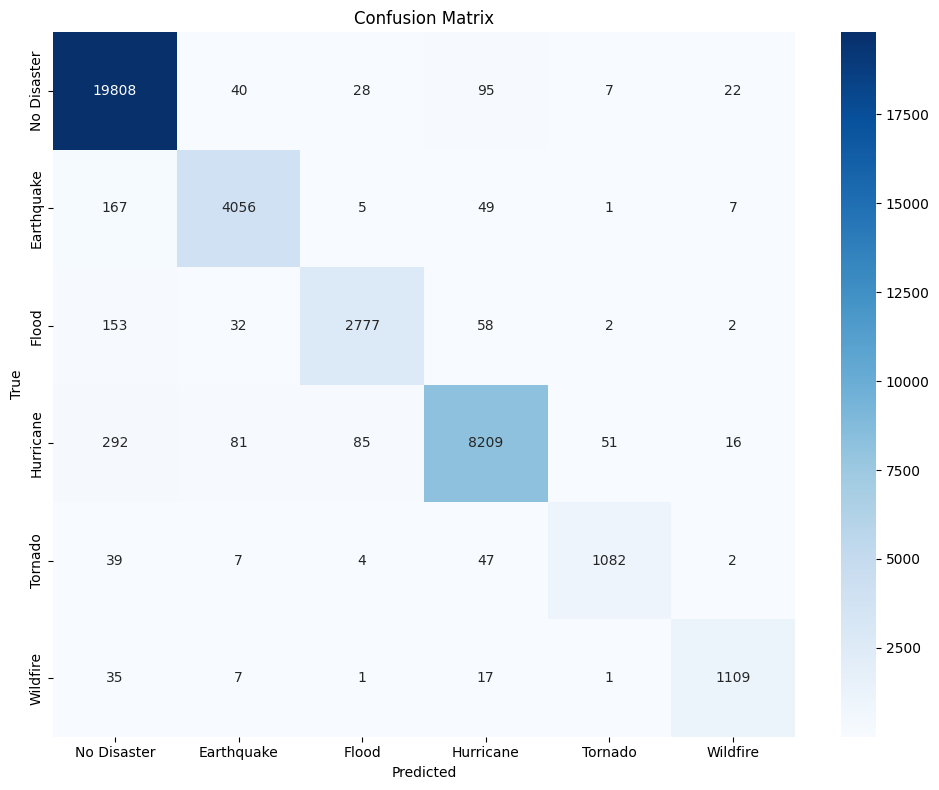

In [ ]:
# Print classification report
print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=disaster_types))

# Create confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=disaster_types, yticklabels=disaster_types)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## Inference Function for New Tweets

In [ ]:
def predict_disaster(text, model, word_to_idx, max_length=50):
    # Clean and tokenize text
    cleaned_text = clean_text(text)
    tokens = tokenize(cleaned_text, word_to_idx, max_length)
    
    # Convert to tensor and add batch dimension
    tokens_tensor = torch.tensor([tokens], dtype=torch.long).to(device)
    
    # Set model to evaluation mode
    model.eval()
    
    # Make prediction
    with torch.no_grad():
        outputs = model(tokens_tensor)
        probabilities = F.softmax(outputs, dim=1)
        predicted_class = outputs.argmax(dim=1).item()
        confidence = probabilities[0][predicted_class].item()
    
    return {
        'text': text,
        'predicted_class': predicted_class,
        'disaster_type': disaster_types[predicted_class],
        'confidence': confidence * 100,
        'probabilities': {disaster_types[i]: prob.item() * 100 for i, prob in enumerate(probabilities[0])}
    }

## Test with Example Tweets

In [ ]:
# Test with some example tweets
example_tweets = [
    "Earthquake just hit the city! Buildings are shaking and people are running outside.",
    "The river has overflowed and many streets are now underwater. #flooding",
    "Hurricane warning in effect for the coastal areas. Everyone please evacuate.",
    "Just saw a tornado touch down near the highway. It's moving east quickly.",
    "The wildfire is spreading rapidly due to strong winds. Fire crews are responding.",
    "Just had a great lunch at the new restaurant downtown. Would recommend!"
]

for tweet in example_tweets:
    result = predict_disaster(tweet, model, word_to_idx)
    print(f"Text: {result['text']}")
    print(f"Predicted: {result['disaster_type']} (Class {result['predicted_class']})")
    print(f"Confidence: {result['confidence']:.2f}%")
    print("Probabilities:")
    for disaster_type, prob in result['probabilities'].items():
        print(f"  {disaster_type}: {prob:.2f}%")
    print("-" * 80)

Text: Earthquake just hit the city! Buildings are shaking and people are running outside.
Predicted: Earthquake (Class 1)
Confidence: 99.95%
Probabilities:
  No Disaster: 0.01%
  Earthquake: 99.95%
  Flood: 0.00%
  Hurricane: 0.04%
  Tornado: 0.00%
  Wildfire: 0.00%
--------------------------------------------------------------------------------
Text: The river has overflowed and many streets are now underwater. #flooding
Predicted: Hurricane (Class 3)
Confidence: 46.27%
Probabilities:
  No Disaster: 10.87%
  Earthquake: 1.24%
  Flood: 39.37%
  Hurricane: 46.27%
  Tornado: 1.18%
  Wildfire: 1.08%
--------------------------------------------------------------------------------
Text: Hurricane warning in effect for the coastal areas. Everyone please evacuate.
Predicted: Hurricane (Class 3)
Confidence: 99.97%
Probabilities:
  No Disaster: 0.02%
  Earthquake: 0.00%
  Flood: 0.00%
  Hurricane: 99.97%
  Tornado: 0.00%
  Wildfire: 0.00%
--------------------------------------------------------

## Save Model and Vocabulary for Future Use

In [ ]:
import os
import pickle
import json
from sklearn.metrics import f1_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight

# Create directory for model artifacts
MODEL_DIR = 'disaster_model'
os.makedirs(MODEL_DIR, exist_ok=True)

# Save model state
torch.save(model.state_dict(), os.path.join(MODEL_DIR, 'model_state_dict.pt'))
torch.save(model, os.path.join(MODEL_DIR, 'model_full.pt'))

# Save model configuration for reconstruction
model_config = {
    'vocab_size': VOCAB_SIZE,
    'embedding_dim': EMBEDDING_DIM,
    'hidden_dim': HIDDEN_DIM,
    'output_dim': OUTPUT_DIM,
    'n_layers': N_LAYERS,
    'bidirectional': BIDIRECTIONAL,
    'dropout': DROPOUT,
    'pad_idx': PAD_IDX,
    'max_length': MAX_LENGTH
}

# Save vocabulary and configurations
with open(os.path.join(MODEL_DIR, 'vocab.pkl'), 'wb') as f:
    pickle.dump(vocab, f)

with open(os.path.join(MODEL_DIR, 'word_to_idx.pkl'), 'wb') as f:
    pickle.dump(word_to_idx, f)

with open(os.path.join(MODEL_DIR, 'model_config.json'), 'w') as f:
    json.dump(model_config, f)

with open(os.path.join(MODEL_DIR, 'disaster_types.json'), 'w') as f:
    json.dump(disaster_types, f)

print(f"Model and vocabulary saved to {MODEL_DIR}/")

# Additional evaluation metrics - Per-class F1 scores

# Calculate per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(test_labels, test_preds)

# Create a dataframe with per-class metrics
metrics_df = pd.DataFrame({
    'Disaster Type': disaster_types,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Support': support
})

print("\nPer-class metrics:")
print(metrics_df)

# Plot F1 scores
# plt.figure(figsize=(10, 6))
# plt.bar(disaster_types, f1)
# plt.title('F1 Scores by Disaster Type')
# plt.xlabel('Disaster Type')
# plt.ylabel('F1 Score')
# plt.ylim(0, 1.0)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# Class imbalance handling - Calculate class weights

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

print("\nClass weights to handle imbalance:")
for i, weight in enumerate(class_weights):
    print(f"{disaster_types[i]}: {weight:.4f}")

# Create a deployable prediction pipeline
class DisasterPredictor:
    def __init__(self, model_dir='disaster_model'):
        # Load configuration
        with open(os.path.join(model_dir, 'model_config.json'), 'r') as f:
            self.config = json.load(f)
        
        # Load vocabulary
        with open(os.path.join(model_dir, 'vocab.pkl'), 'rb') as f:
            self.vocab = pickle.load(f)
            
        with open(os.path.join(model_dir, 'word_to_idx.pkl'), 'rb') as f:
            self.word_to_idx = pickle.load(f)
            
        with open(os.path.join(model_dir, 'disaster_types.json'), 'r') as f:
            self.disaster_types = json.load(f)
        
        # Initialize model
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = LSTMClassifier(
            self.config['vocab_size'], 
            self.config['embedding_dim'], 
            self.config['hidden_dim'], 
            self.config['output_dim'], 
            self.config['n_layers'], 
            self.config['bidirectional'], 
            self.config['dropout'], 
            self.config['pad_idx']
        )
        
        # Load model weights
        # Register the LSTMClassifier class for safe loading
        torch.serialization.add_safe_globals([LSTMClassifier])
        
        # Load model weights
        self.model.load_state_dict(torch.load(
            os.path.join(model_dir, 'model_state_dict.pt'),
            map_location=self.device
        ))
        
        # Alternatively, to load the full model (if needed)
        # self.model = torch.load(
        #     os.path.join(model_dir, 'model_full.pt'),
        #     map_location=self.device,
        #     weights_only=False
        # )
        
        self.model.to(self.device)
        self.model.eval()
    
    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'@\w+|#\w+', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    def tokenize(self, text):
        max_length = self.config['max_length']
        words = text.split()
        tokens = [self.word_to_idx.get(word, self.word_to_idx['<UNK>']) for word in words]
        
        # Pad or truncate
        if len(tokens) < max_length:
            tokens = tokens + [self.word_to_idx['<PAD>']] * (max_length - len(tokens))
        else:
            tokens = tokens[:max_length]
        
        return tokens
    
    def predict(self, text):
        # Clean and tokenize
        cleaned_text = self.clean_text(text)
        tokens = self.tokenize(cleaned_text)
        
        # Convert to tensor
        tensor = torch.LongTensor([tokens]).to(self.device)
        
        # Get prediction
        with torch.no_grad():
            outputs = self.model(tensor)
            probabilities = F.softmax(outputs, dim=1)
            predicted_class = outputs.argmax(dim=1).item()
            confidence = probabilities[0][predicted_class].item()
        
        return {
            'text': text,
            'predicted_class': predicted_class,
            'disaster_type': self.disaster_types[predicted_class],
            'confidence': confidence * 100,
            'probabilities': {self.disaster_types[i]: prob.item() * 100 for i, prob in enumerate(probabilities[0])}
        }

# Test the predictor pipeline
print("\nTesting prediction pipeline...")
predictor = DisasterPredictor()

# Test examples with the pipeline
for tweet in example_tweets:
    result = predictor.predict(tweet)
    print(f"\nText: {result['text']}")
    print(f"Predicted: {result['disaster_type']} (Class {result['predicted_class']})")
    print(f"Confidence: {result['confidence']:.2f}%")

Model and vocabulary saved to disaster_model/

Per-class metrics:
  Disaster Type  Precision    Recall  F1 Score  Support
0   No Disaster   0.966527  0.990400  0.978318    20000
1    Earthquake   0.960455  0.946558  0.953456     4285
2         Flood   0.957586  0.918320  0.937542     3024
3     Hurricane   0.968614  0.939890  0.954036     8734
4       Tornado   0.945804  0.916173  0.930753     1181
5      Wildfire   0.957686  0.947863  0.952749     1170

Class weights to handle imbalance:
No Disaster: 0.3200
Earthquake: 1.4931
Flood: 2.1158
Hurricane: 0.7327
Tornado: 5.4198
Wildfire: 5.4708

Testing prediction pipeline...

Text: Earthquake just hit the city! Buildings are shaking and people are running outside.
Predicted: Earthquake (Class 1)
Confidence: 99.95%

Text: The river has overflowed and many streets are now underwater. #flooding
Predicted: Hurricane (Class 3)
Confidence: 46.27%

Text: Hurricane warning in effect for the coastal areas. Everyone please evacuate.
Predicted: Hurr